# Affect Modeling LM

This is the model file for linear models

## Load Data and Packages

In [5]:
library(RWiener)
library(dplyr)
library(loo)
library(coda)
library(rjags)
set.seed(1998)

setwd("C:/Users/u0145642/OneDrive - KU Leuven/Desktop/PhD/Project 3 Data Analysis Tomi/data")
data <- read.table("scale_18-06-2024_cleaned_rt5000ms100ms.csv", header = TRUE, sep = ",")  # Adjust 'sep' based on your file's delimiter

##############################################preprocessing###################################################
##############################################################################################################

#assign an index from 1 to n to participants
data$Sub = as.numeric(factor(data$participant, levels = unique(data$participant)))

# Separate the column 'outcome_report' into two columns 'outcome.report.win' and 'outcome.report.loss'
data <- cbind(data, do.call(rbind, strsplit(gsub("\\[|\\]", "", data$outcome_report), ",")))
# Rename the columns
names(data)[names(data) == "1"] <- "outcome.report.win"
names(data)[names(data) == "2"] <- "outcome.report.loss"         

#Separate "probability" into "probability.win" and "probability.loss"
data$probability.win = ifelse(data$probability %in% c(1,2,3), 0 ,1)
data$probability.loss = ifelse(data$probability %in% c(1,2,3), 1,0)
#create prediction error for winning & losing condition
data$prediction.error.win = ifelse(data$outcome >0, data$probability.loss ,0)
data$prediction.error.loss = ifelse(data$outcome < 0, data$probability.win ,0)
#create prediction error for m5
data$prediction.error = ifelse(data$outcome>0, data$probability.loss, data$probability.win)
#convert true outcome to its absolute value
data$outcome.absolute.win = ifelse(data$outcome>0, abs(data$outcome), 0)
data$outcome.absolute.loss = ifelse(data$outcome<0, abs(data$outcome), 0)

#convert affect scale 0-1 to 0-100 and create a lag-1 variable
data$affect = 100 * data$affect
data$affect.lag.1 <- c(NA, data$affect[-nrow(data)])
data$affect.lag.1[which(!duplicated(data$Sub))] <- 0

#Source Kruschke's diagnostic MCMC functions
source("C:/Users/u0145642/OneDrive - KU Leuven/Desktop/PhD/JAGS hierarchical model Johnson 2017/DBDA2E-utilities.R")



*********************************************************************
Kruschke, J. K. (2015). Doing Bayesian Data Analysis, Second Edition:
A Tutorial with R, JAGS, and Stan. Academic Press / Elsevier.
*********************************************************************



### Model 1

In [3]:
data_model_m1=list(
  nTrials = length(data$affect),
  nSubject = length(unique(data$Sub)),
  nVar = 3,
  subject = data$Sub,
  o.true = data$outcome,
  y = data$affect,
  y_previous = data$affect.lag.1,
  Rscal = 3 ,  # for dwish prior
  Rmat = diag(x=1,nrow = 3))



model_String_m1 ='
model {

  #likelihood function
  for (t in 1:nTrials) {
      
      y[t] ~ dnorm(beta[subject[t],1] + beta[subject[t],2] * o.true[t] + 
                    beta[subject[t],3] *y_previous[t], precy)
  }
  
  #looic
  
  for (t in 1:nTrials) {
     
   
      ld[t] = logdensity.norm(y[t], beta[subject[t],1] + beta[subject[t],2] * o.true[t] + 
                    beta[subject[t],3] *y_previous[t], precy)
  }
  
    
  #priors
  for (i in 1:nSubject) {
    beta[i,1:nVar] ~ dmnorm(Mu[1:nVar], InvCovMat[1:nVar,1:nVar])
  }
  precy ~ dgamma(.001,.001)
  
  for (varIdx in 1:nVar) { 
  Mu[varIdx] ~ dnorm( 0 , 1e-3 ) }
  
  InvCovMat ~ dwish(Rmat[1:nVar,1:nVar], Rscal )
  CovMat <- inverse( InvCovMat )
  
  for ( varIdx in 1:nVar ) { 
    Sigma[varIdx] <- sqrt(CovMat[varIdx,varIdx]) }
  for ( varIdx1 in 1:nVar ) { 
    for ( varIdx2 in 1:nVar ) {
      Rho[varIdx1,varIdx2] <- ( CovMat[varIdx1,varIdx2]
                               / (Sigma[varIdx1]*Sigma[varIdx2]) )
  } }
}

'

writeLines(model_String_m1, con = 'm1.txt')


#Create list of parameters to be monitored
parameters_m1 <- c("beta", "Mu", "Sigma", 
                   "Rho","ld")



#Run the model in runjags
startTime = proc.time()
jagsModel_m1 <- run.jags(method = "parallel",
                         model = 'm1.txt',
                         monitor = parameters_m1,
                         data = data_model_m1,
                         n.chains = 3,
                         adapt = 3000, #how long the samplers "tune"
                         burnin = 3000, #how long of a burn in
                         sample = 3000,
                         thin = 3, #thin if high autocorrelation to avoid huge files
                         summarise = T,
                         plots = T)
stopTime = proc.time()
elapsedTime = stopTime - startTime
print(elapsedTime/60) #Tells how long it took to run analysis

save(jagsModel_m1, file = "jags_sample_m1.RData")

Calling 3 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.1 on Wed Jun 19 11:12:08 2024
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 40396
   Unobserved stochastic nodes: 221
   Total graph size: 259374
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 3000
-------------------------------------------------| 3000
************************************************** 100%
. . . . . . Updating 9000
-------------------------------------------------| 9000
************************************************** 100%
. . . . Updating 0
. Deleting model
All chains have finished
Note: the model did

### Model 2

In [ ]:
data_model_m2=list(
  nTrials = length(data$affect),
  nSubject = length(unique(data$Sub)),
  nVar = 5,
  subject = data$Sub,
  o.abs.win = data$outcome.absolute.win,
  o.abs.loss = data$outcome.absolute.loss,
  o.dummy.win = ifelse(data$outcome>0, 1, 0),
  y = data$affect,
  y_previous = data$affect.lag.1,
  Rscal = 5 ,  # for dwish prior
  Rmat = diag(x=1,nrow = 5))



model_String_m2 ='
model {

  #likelihood function
  for (t in 1:nTrials) {
      
      y[t] ~ dnorm(beta[subject[t],1] + beta[subject[t],2] * o.dummy.win[t] + beta[subject[t],3] * o.abs.win[t] + 
                    beta[subject[t],4] * o.abs.loss[t] + beta[subject[t],5] *y_previous[t], precy)
  }
  
  #looic
  
  for (t in 1:nTrials) {
     
   
      ld[t] = logdensity.norm(y[t], beta[subject[t],1] + beta[subject[t],2] * o.dummy.win[t] + beta[subject[t],3] * o.abs.win[t] + 
                    beta[subject[t],4] * o.abs.loss[t] + beta[subject[t],5] *y_previous[t], precy)
  }
  
    
  #priors
  for (i in 1:nSubject) {
    beta[i,1:nVar] ~ dmnorm(Mu[1:nVar], InvCovMat[1:nVar,1:nVar])
  }
  precy ~ dgamma(.001,.001)
  
  for (varIdx in 1:nVar) { 
  Mu[varIdx] ~ dnorm( 0 , 1e-3 ) }
  
  InvCovMat ~ dwish(Rmat[1:nVar,1:nVar], Rscal )
  CovMat <- inverse( InvCovMat )
  
  for ( varIdx in 1:nVar ) { 
    Sigma[varIdx] <- sqrt(CovMat[varIdx,varIdx]) }
  for ( varIdx1 in 1:nVar ) { 
    for ( varIdx2 in 1:nVar ) {
      Rho[varIdx1,varIdx2] <- ( CovMat[varIdx1,varIdx2]
                               / (Sigma[varIdx1]*Sigma[varIdx2]) )
  } }
}

'

writeLines(model_String_m2, con = 'm2.txt')


#Create list of parameters to be monitored
parameters_m2 <- c("beta", "Mu", "Sigma", 
                "Rho","ld")



#Run the model in runjags
startTime = proc.time()
jagsModel_m2 <- run.jags(method = "parallel",
                      model = 'm2.txt',
                      monitor = parameters_m2,
                      data = data_model_m2,
                      n.chains = 3,
                      adapt = 3000, #how long the samplers "tune"
                      burnin = 3000, #how long of a burn in
                      sample = 3000,
                      thin = 3, #thin if high autocorrelation to avoid huge files
                      summarise = T,
                      plots = T)
stopTime = proc.time()
elapsedTime = stopTime - startTime
show(elapsedTime/60) #Tells how long it took to run analysis

save(jagsModel_m2, file = "jags_sample_m2.RData")

### Model 3

In [6]:
data_model_m3=list(
  nTrials = length(data$affect),
  nSubject = length(unique(data$Sub)),
  subject = data$Sub,
  o = data$outcome,
  o.abs.win = data$outcome.absolute.win,
  o.abs.loss = data$outcome.absolute.loss,
  pe.win = data$prediction.error.win,
  pe.loss = data$prediction.error.loss,
  o.pe.win = ifelse(data$outcome>0,((data$outcome.absolute.win-mean(data$outcome.absolute.win))*(data$prediction.error.win-mean(data$prediction.error.win))),0),
  o.pe.loss = ifelse(data$outcome<0,((data$outcome.absolute.loss-mean(data$outcome.absolute.loss))*(data$prediction.error.loss-mean(data$prediction.error.loss))),0),
  y = data$affect,
  y_previous = data$affect.lag.1,
  o.dummy = ifelse(data$outcome>0,1,0),
  nVar = 9,
  Rscal = 11 ,  # for dwish prior
  Rmat = diag(x=1,nrow = 9))



model_String_m3 ='
model {

  #likelihood function
  for (t in 1:nTrials) {
      
      
      
      y[t] ~ dnorm(beta[subject[t],1] +  beta[subject[t],2] * o.dummy[t] + beta[subject[t],3] * o.abs.win[t] + beta[subject[t],6] * o.abs.loss[t] + 
                    beta[subject[t],4] * pe.win[t] + beta[subject[t],7] * pe.loss[t] +
                    beta[subject[t],5] * o.pe.win[t] + beta[subject[t],8] * o.pe.loss[t] +
                    beta[subject[t],9] * y_previous[t], precy)
  }
  
  #looic
  
  for (t in 1:nTrials) {
     
   
      ld[t] = logdensity.norm(y[t], beta[subject[t],1] +  beta[subject[t],2] * o.dummy[t] +  beta[subject[t],3] * o.abs.win[t] + beta[subject[t],6] * o.abs.loss[t] + 
                    beta[subject[t],4] * pe.win[t] + beta[subject[t],7] * pe.loss[t] +
                    beta[subject[t],5] * o.pe.win[t] + beta[subject[t],8] * o.pe.loss[t] +
                    beta[subject[t],9] * y_previous[t], precy)
                    
      y_pred[t] ~ dnorm( beta[subject[t],1] +  beta[subject[t],2] * o.dummy[t] +  beta[subject[t],3] * o.abs.win[t] + beta[subject[t],6] * o.abs.loss[t] + 
                    beta[subject[t],4] * pe.win[t] + beta[subject[t],7] * pe.loss[t] +
                    beta[subject[t],5] * o.pe.win[t] + beta[subject[t],8] * o.pe.loss[t] +
                    beta[subject[t],9] * y_previous[t], precy)
  }
  
    
  #priors
  for (i in 1:nSubject) {
    beta[i,1:nVar] ~ dmnorm(Mu[1:nVar], InvCovMat[1:nVar,1:nVar])
  }
  precy ~ dgamma(.001,.001)
  Sigmay = sqrt(1/precy)
  for (varIdx in c(1,3:nVar)) { 
  Mu[varIdx] ~ dnorm( 0 , 1e-3 )
  }
  
  Mu[2] ~ dnorm( 0 , 1e-3 )T(0,)
  
  
  #dwish(R, k), R is a postive definite m*m matrix (symmetric & square), k is degrees of freedom >= m
  #When R is diagonal and k = m + 1, the correlation parameters have a uniform distribution on the interval [-1,1]
  InvCovMat ~ dwish(Rmat[1:nVar,1:nVar], Rscal)
  CovMat <- inverse( InvCovMat )
  
  for ( varIdx in 1:nVar ) { 
    Sigma[varIdx] <- sqrt(CovMat[varIdx,varIdx]) 
  }
  for ( varIdx1 in 1:nVar ) { 
    for ( varIdx2 in 1:nVar ) {
      Rho[varIdx1,varIdx2] <- ( CovMat[varIdx1,varIdx2]
                               / (Sigma[varIdx1]*Sigma[varIdx2]) )
  } 
  }
 
 for (i in 1:nSubject){
  beta.transformed[i, 1] = beta[i,1] + beta[i,3] * mean(o.abs.win)
  beta.transformed[i, 2] = beta[i,2] + beta[i,6] * mean(o.abs.win)
  beta.transformed[i, 3] = beta[i,3] - mean(o.abs.win)
  beta.transformed[i, 4] = beta[i,4] - mean(pe.win)
  beta.transformed[i, 5] = beta[i,5] 
  beta.transformed[i, 6] = beta[i,6] - mean(o.abs.loss)
  beta.transformed[i, 7] = beta[i,7] - mean(pe.loss)
  beta.transformed[i, 8] = beta[i,8] 
  beta.transformed[i, 9] = beta[i,9] 
 }
  Mu.transformed[1] = Mu[1] + Mu[3] * mean(o.abs.win)
  Mu.transformed[2] = Mu[2] + Mu[6] * mean(o.abs.win)
  Mu.transformed[3] = Mu[3] - mean(o.abs.win)
  Mu.transformed[4] = Mu[4] - mean(pe.win)
  Mu.transformed[5] = Mu[5] 
  Mu.transformed[6] = Mu[6] - mean(o.abs.loss)
  Mu.transformed[7] = Mu[7] - mean(pe.loss)
  Mu.transformed[8] = Mu[8] 
  Mu.transformed[9] = Mu[9]
}

'

writeLines(model_String_m3, con = 'm3.txt')


#Create list of parameters to be monitored
parameters_m3 <- c("beta", "Mu", "Sigma", 
                            "Rho", "Sigmay", "beta.transformed",
                            "Mu.transformed")



#Run the model in runjags
startTime = proc.time()
jagsModel_m3 <- run.jags(method = "parallel",
                                  model = 'm3.txt',
                                  monitor = parameters_m3,
                                  data = data_model_m3,
                                  n.chains = 3,
                                  adapt = 3000, #how long the samplers "tune"
                                  burnin = 3000, #how long of a burn in
                                  sample = 3000,
                                  thin = 10, #thin if high autocorrelation to avoid huge files
                                  summarise = T,
                                  plots = T)
stopTime = proc.time()
elapsedTime = stopTime - startTime
print(elapsedTime/60) #Tells how long it took to run analysis

save(jagsModel_m3, file = "jags_sample_m3_two_Itcp.RData")
R_hat_m3 = gelman.diag(as.mcmc.list(jagsModel_m3), multivariate = F)
length(which(as.numeric(R_hat_m3$psrf[,"Point est."])>1.05))


Calling 3 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.1 on Tue Jun 18 15:52:19 2024
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 2252
   Unobserved stochastic nodes: 2275
   Total graph size: 33695

o

. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 3000
-------------------------------------------------| 3000
************************************************** 100%
. . . . . . . . Updating 30000
-------------------------------------------------| 30000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: t

[1] 4

In [15]:
R_hat_m3 = gelman.diag(as.mcmc.list(jagsModel_m3), multivariate = F)
length(which(as.numeric(R_hat_m3$psrf[,"Point est."])>1.05))

[1] 7

In [7]:
mcmc_m3 = as.matrix(as.mcmc.list(jagsModel_m3), chains = F)
quantiles <- apply(mcmc_m3, 2, function(x) quantile(x, c(0.025, 0.975)))
posterior_mean =  colMeans(mcmc_m3)

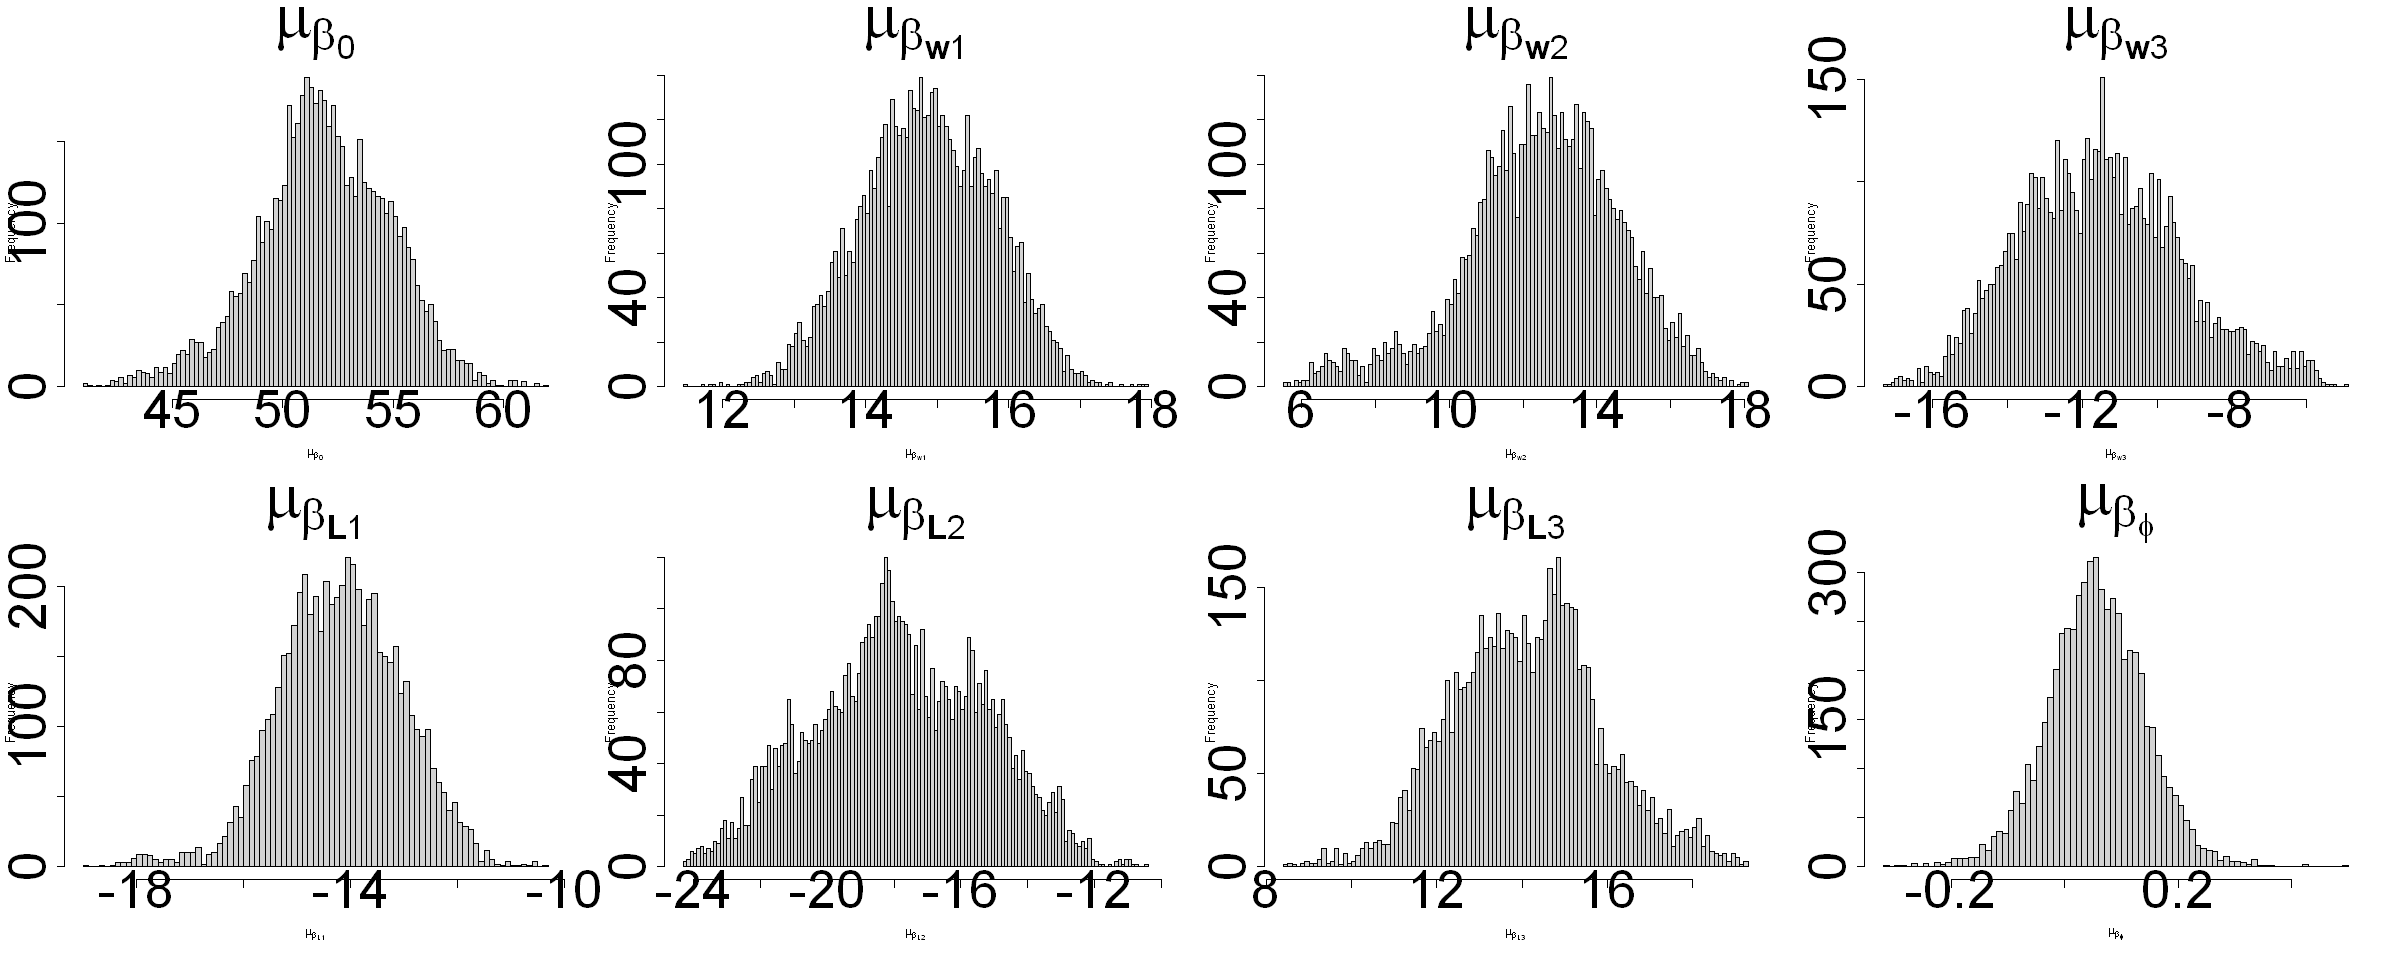

In [47]:
par(mfrow = c(2, 4), cex.main = 5, cex.axis=4)
options(repr.plot.width = 20, repr.plot.height = 8)  
hist(mcmc_m3[, "Mu[1]"], breaks = 100, main = expression(mu[bold(beta[0])]), xlab = expression(mu[bold(beta[0])]))
hist(mcmc_m3[, "Mu[2]"], breaks = 100, main = expression(mu[bold(beta[w1])]), xlab = expression(mu[bold(beta[w1])]))
hist(mcmc_m3[, "Mu[3]"], breaks = 100, main = expression(mu[bold(beta[w2])]), xlab = expression(mu[bold(beta[w2])]))
hist(mcmc_m3[, "Mu[4]"], breaks = 100, main = expression(mu[bold(beta[w3])]), xlab = expression(mu[bold(beta[w3])]))
hist(mcmc_m3[, "Mu[5]"], breaks = 100, main = expression(mu[bold(beta[L1])]), xlab = expression(mu[bold(beta[L1])]))
hist(mcmc_m3[, "Mu[6]"], breaks = 100, main = expression(mu[bold(beta[L2])]), xlab = expression(mu[bold(beta[L2])]))
hist(mcmc_m3[, "Mu[7]"], breaks = 100, main = expression(mu[bold(beta[L3])]), xlab = expression(mu[bold(beta[L3])]))
hist(mcmc_m3[, "Mu[8]"], breaks = 100, main = expression(mu[bold(beta[phi])]), xlab = expression(mu[bold(beta[phi])]))

In [18]:
R_hat_m3_two_Itcp = gelman.diag(as.mcmc.list(jagsModel_m3_two_Itcp), multivariate = F)
print(R_hat_m3_two_Itcp)
#length(which(as.numeric(R_hat_m3_two_Itcp$psrf[,"Point est."])>1.05))

Potential scale reduction factors:

           Point est. Upper C.I.
beta[1,1]        1.01       1.04
beta[2,1]        1.01       1.05
beta[3,1]        1.00       1.01
beta[4,1]        1.01       1.03
beta[5,1]        1.02       1.07
beta[6,1]        1.01       1.02
beta[7,1]        1.05       1.17
beta[8,1]        1.01       1.01
beta[9,1]        1.02       1.05
beta[10,1]       1.01       1.01
beta[11,1]       1.05       1.18
beta[12,1]       1.09       1.29
beta[1,2]        1.02       1.06
beta[2,2]        1.04       1.12
beta[3,2]        1.02       1.07
beta[4,2]        1.01       1.02
beta[5,2]        1.01       1.04
beta[6,2]        1.00       1.00
beta[7,2]        1.04       1.14
beta[8,2]        1.00       1.01
beta[9,2]        1.01       1.02
beta[10,2]       1.01       1.02
beta[11,2]       1.03       1.09
beta[12,2]       1.04       1.12
beta[1,3]        1.04       1.12
beta[2,3]        1.03       1.10
beta[3,3]        1.01       1.02
beta[4,3]        1.03       1.05
beta[5,

In [6]:
mcmc_m3_two_Itcp = as.matrix(as.mcmc.list(jagsModel_m3_two_Itcp), chains = F)
quantiles <- apply(mcmc_m3_two_Itcp, 2, function(x) quantile(x, c(0.025, 0.975)))
posterior_mean =  colMeans(mcmc_m3_two_Itcp)

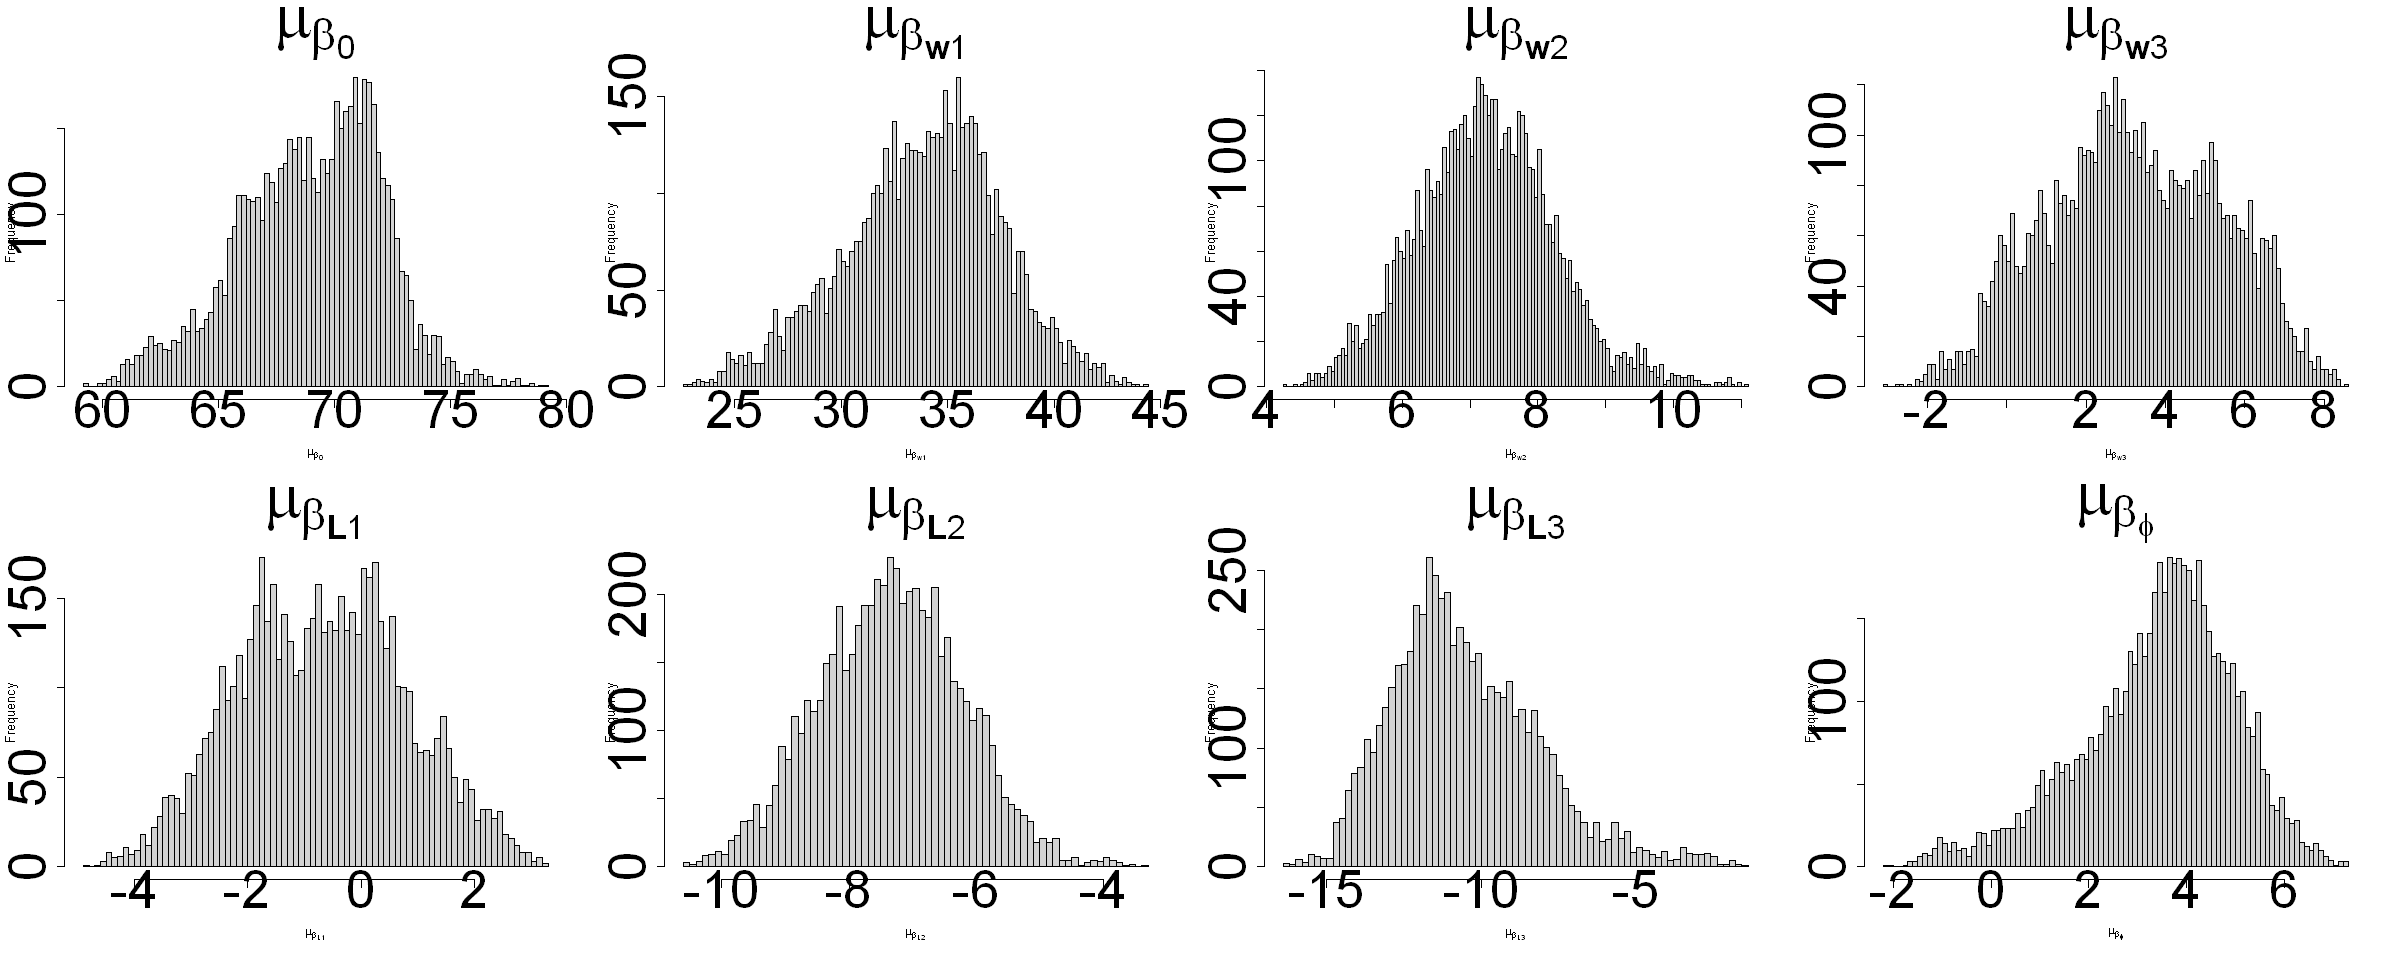

In [8]:
par(mfrow = c(2, 4), cex.main = 5, cex.axis=4)
options(repr.plot.width = 20, repr.plot.height = 8)  
hist(mcmc_m3_two_Itcp[, "Mu[1]"], breaks = 100, main = expression(mu[bold(beta[0])]), xlab = expression(mu[bold(beta[0])]))
hist(mcmc_m3_two_Itcp[, "Mu[2]"], breaks = 100, main = expression(mu[bold(beta[w1])]), xlab = expression(mu[bold(beta[w1])]))
hist(mcmc_m3_two_Itcp[, "Mu[3]"], breaks = 100, main = expression(mu[bold(beta[w2])]), xlab = expression(mu[bold(beta[w2])]))
hist(mcmc_m3_two_Itcp[, "Mu[4]"], breaks = 100, main = expression(mu[bold(beta[w3])]), xlab = expression(mu[bold(beta[w3])]))
hist(mcmc_m3_two_Itcp[, "Mu[5]"], breaks = 100, main = expression(mu[bold(beta[L1])]), xlab = expression(mu[bold(beta[L1])]))
hist(mcmc_m3_two_Itcp[, "Mu[6]"], breaks = 100, main = expression(mu[bold(beta[L2])]), xlab = expression(mu[bold(beta[L2])]))
hist(mcmc_m3_two_Itcp[, "Mu[7]"], breaks = 100, main = expression(mu[bold(beta[L3])]), xlab = expression(mu[bold(beta[L3])]))
hist(mcmc_m3_two_Itcp[, "Mu[8]"], breaks = 100, main = expression(mu[bold(beta[phi])]), xlab = expression(mu[bold(beta[phi])]))

### Model 4

In [2]:
library(RWiener)
library(dplyr)
library(loo)
library(coda)
library(rjags)
#set.seed(1998)


data_model_m4=list(
  nTrials = length(data$affect),
  nSubject = length(unique(data$Sub)),
  nVar = 4,
  subject = data$Sub,
  o.true = data$outcome,
  o.win = as.numeric(data$outcome.report.win),
  o.loss = as.numeric(data$outcome.report.loss),
  p.win = data$probability.win,
  p.loss = data$probability.loss,
  y = data$affect,
  y_previous = data$affect.lag.1,
  Rscal = 4 ,  # for dwish prior
  Rmat = diag(x=1,nrow = 4))



#wrong
model_String_m4 ='
model {

  #likelihood function
  for (t in 1:nTrials) {
      
      y[t] ~ dnorm(beta[subject[t],1] + beta[subject[t],2] * (o.true[t] - (2 * (1/(1+exp(-beta[subject[t],3]))) * o.win[t] * p.win[t] + (2 - 2 * (1/(1+exp(-beta[subject[t],3])))) * o.loss[t] * p.loss[t]))+
                    beta[subject[t],4] *y_previous[t], precy)
  }
  
  #looic
  
  for (t in 1:nTrials) {
     
   
      ld[t] = logdensity.norm(y[t], beta[subject[t],1] + beta[subject[t],2] * (o.true[t] - (2 * (1/(1+exp(-beta[subject[t],3]))) * o.win[t] * p.win[t] + (2 - 2 * (1/(1+exp(-beta[subject[t],3])))) * o.loss[t] * p.loss[t]))+
                    beta[subject[t],4] *y_previous[t], precy)
  }
  
    
  #priors
  for (i in 1:nSubject) {
    beta[i,1:nVar] ~ dmnorm(Mu[1:nVar], InvCovMat[1:nVar,1:nVar])
  }
  precy ~ dgamma(.001,.001)
  
  for (varIdx in 1:nVar) { 
  Mu[varIdx] ~ dnorm( 0 , 1e-3 ) }
  
  InvCovMat ~ dwish(Rmat[1:nVar,1:nVar], Rscal )
  CovMat <- inverse( InvCovMat )
  
  for ( varIdx in 1:nVar ) { 
    Sigma[varIdx] <- sqrt(CovMat[varIdx,varIdx]) }
  for ( varIdx1 in 1:nVar ) { 
    for ( varIdx2 in 1:nVar ) {
      Rho[varIdx1,varIdx2] <- ( CovMat[varIdx1,varIdx2]
                               / (Sigma[varIdx1]*Sigma[varIdx2]) )
  } }
}

'

writeLines(model_String_m4, con = 'm4.txt')


#Create list of parameters to be monitored
parameters_m4 <- c("beta", "Mu", "Sigma", 
                   "Rho","ld")



#Run the model in runjags
startTime = proc.time()
jagsModel_m4 <- run.jags(method = "parallel",
                         model = 'm4.txt',
                         monitor = parameters_m4,
                         data = data_model_m4,
                         n.chains = 3,
                         adapt = 3000, #how long the samplers "tune"
                         burnin = 3000, #how long of a burn in
                         sample = 3000,
                         thin = 3, #thin if high autocorrelation to avoid huge files
                         summarise = T,
                         plots = T)
stopTime = proc.time()
elapsedTime = stopTime - startTime
show(elapsedTime/60) #Tells how long it took to run analysis

save(jagsModel_m4, file = "jags_sample_m4.RData")


Calling 3 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.1 on Mon Jun 24 15:41:13 2024
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 40396
   Unobserved stochastic nodes: 222
   Total graph size: 437743
. Reading parameter file inits1.txt
. Initializing model
. Adapting 3000
-------------------------------------------------| 3000
++++++++++++++++++++++++++++++++++++++++++++++++++ 100%
Adaptation incomplete.
. Updating 3000
-------------------------------------------------| 3000
************************************************** 100%
. . . . . . Updating 9000
-------------------------------------------------| 9000
**************************************

Warning message:
"The adaptation phase of one or more models was not completed in 3000 iterations, so the current samples may not be optimal - try increasing the number of iterations to the "adapt" argument"


NOTE: The JAGS output file(s) appear(s) to be very large - they may
take some time to read.  Have you accidentally included a large vector
in "monitor", or are you trying to run too many iterations without
specifying "thin"?If the read-in process fails (or is aborted), use ?results.jags and the
read.monitor argument to retrieve the simulationSimulation complete.  Reading coda files...
Coda files loaded successfully
Note: Summary statistics were not produced as there are >50 monitored
variables
[To override this behaviour see ?add.summary and ?runjags.options]
FALSEFinished running the simulation
     user    system   elapsed 
11.993667  2.233167 33.569500 


In [7]:
data_model_m4=list(
  nTrials = length(data$affect),
  nSubject = length(unique(data$Sub)),
  nVar = 4,
  subject = data$Sub,
  o.true = data$outcome,
  o.win = as.numeric(data$outcome.report.win),
  o.loss = as.numeric(data$outcome.report.loss),
  p.win = data$probability.win,
  p.loss = data$probability.loss,
  y = data$affect,
  y_previous = data$affect.lag.1,
  Rscal = 6 ,  # for dwish prior
  Rmat = diag(x=1,nrow = 4))


#wrong 
model_String_m4 ='
model {

  #likelihood function
  for (t in 1:nTrials) {
      
      y[t] ~ dnorm(beta[subject[t],1] + beta[subject[t],2] * (o.true[t] - (2 * (1/(1+exp(-beta[subject[t],3]))) * o.win[t] * p.win[t] + (2 - 2 * (1/(1+exp(-beta[subject[t],3])))) * o.loss[t] * p.loss[t]))+
                    beta[subject[t],4] *y_previous[t], precy)
  }
  
  #looic
  
  for (t in 1:nTrials) {
     
   
      ld[t] = logdensity.norm(y[t], beta[subject[t],1] + beta[subject[t],2] * (o.true[t] - (2 * (1/(1+exp(-beta[subject[t],3]))) * o.win[t] * p.win[t] + (2 - 2 * (1/(1+exp(-beta[subject[t],3])))) * o.loss[t] * p.loss[t]))+
                    beta[subject[t],4] *y_previous[t], precy)
  }
  
    
  #priors
  for (i in 1:nSubject) {
    beta[i,1:nVar] ~ dmnorm(Mu[1:nVar], InvCovMat[1:nVar,1:nVar])
  }
  precy ~ dgamma(.001,.001)
  
  for (varIdx in 1:nVar) { 
  Mu[varIdx] ~ dnorm( 0 , 1e-3 ) }
  
  InvCovMat ~ dwish(Rmat[1:nVar,1:nVar], Rscal )
  CovMat <- inverse( InvCovMat )
  
  for ( varIdx in 1:nVar ) { 
    Sigma[varIdx] <- sqrt(CovMat[varIdx,varIdx]) }
  for ( varIdx1 in 1:nVar ) { 
    for ( varIdx2 in 1:nVar ) {
      Rho[varIdx1,varIdx2] <- ( CovMat[varIdx1,varIdx2]
                               / (Sigma[varIdx1]*Sigma[varIdx2]) )
  } }
}

'

writeLines(model_String_m4, con = 'm4.txt')


#Create list of parameters to be monitored
parameters_m4 <- c("beta", "Mu", "Sigma", 
                   "Rho","ld")



#Run the model in runjags
startTime = proc.time()
jagsModel_m4 <- run.jags(method = "parallel",
                         model = 'm4.txt',
                         monitor = parameters_m4,
                         data = data_model_m4,
                         n.chains = 3,
                         adapt = 20000, #how long the samplers "tune"
                         burnin = 3000, #how long of a burn in
                         sample = 3000,
                         thin = 3, #thin if high autocorrelation to avoid huge files
                         summarise = T,
                         plots = T)
stopTime = proc.time()
elapsedTime = stopTime - startTime
show(elapsedTime/60) #Tells how long it took to run analysis

save(jagsModel_m4, file = "jags_sample_m4.RData")


Calling 3 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.1 on Wed Jun 26 22:32:19 2024
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 40396
   Unobserved stochastic nodes: 222
   Total graph size: 437743
. Reading parameter file inits1.txt
. Initializing model
. Adapting 20000
-------------------------------------------------| 20000
++++++++++++++++++++++++++++++++++++++++++++++++++ 100%
Adaptation incomplete.
. Updating 3000
-------------------------------------------------| 3000
************************************************** 100%
. . . . . . Updating 9000
-------------------------------------------------| 9000
************************************

Warning message:
"The adaptation phase of one or more models was not completed in 20000 iterations, so the current samples may not be optimal - try increasing the number of iterations to the "adapt" argument"


NOTE: The JAGS output file(s) appear(s) to be very large - they may
take some time to read.  Have you accidentally included a large vector
in "monitor", or are you trying to run too many iterations without
specifying "thin"?If the read-in process fails (or is aborted), use ?results.jags and the
read.monitor argument to retrieve the simulationSimulation complete.  Reading coda files...
Coda files loaded successfully
Note: Summary statistics were not produced as there are >50 monitored
variables
[To override this behaviour see ?add.summary and ?runjags.options]
FALSEFinished running the simulation
     user    system   elapsed 
11.856000  2.171333 42.970500 


### Model 4*

In [4]:
data_model_m4star=list(
  nTrials = length(data$affect),
  nSubject = length(unique(data$Sub)),
  nVar = 3,
  subject = data$Sub,
  o.true = data$outcome,
  o.win = as.numeric(data$outcome.report.win),
  o.loss = as.numeric(data$outcome.report.loss),
  p.win = data$probability.win,
  p.loss = data$probability.loss,
  y = data$affect,
  y_previous = data$affect.lag.1,
  Rscal = 3,  # for dwish prior
  Rmat = diag(x=1,nrow = 3))



model_String_m4star ='
model {

  #likelihood function
  for (t in 1:nTrials) {
      
      y[t] ~ dnorm(beta[subject[t],1] + beta[subject[t],2] * (o.win[t] * p.win[t] + o.loss[t] * p.loss[t]) +
                    beta[subject[t],3] *y_previous[t], precy)
  }
  
  #looic
  
  for (t in 1:nTrials) {
     
   
      ld[t] = logdensity.norm(y[t], beta[subject[t],1] + beta[subject[t],2] * (o.win[t] * p.win[t] + o.loss[t] * p.loss[t]) +
                    beta[subject[t],3] *y_previous[t], precy)
  }
  
    
  #priors
  for (i in 1:nSubject) {
    beta[i,1:nVar] ~ dmnorm(Mu[1:nVar], InvCovMat[1:nVar,1:nVar])
  }
  precy ~ dgamma(.001,.001)
  
  for (varIdx in 1:nVar) { 
  Mu[varIdx] ~ dnorm( 0 , 1e-3 ) }
  
  InvCovMat ~ dwish(Rmat[1:nVar,1:nVar], Rscal )
  CovMat <- inverse( InvCovMat )
  
  for ( varIdx in 1:nVar ) { 
    Sigma[varIdx] <- sqrt(CovMat[varIdx,varIdx]) }
  for ( varIdx1 in 1:nVar ) { 
    for ( varIdx2 in 1:nVar ) {
      Rho[varIdx1,varIdx2] <- ( CovMat[varIdx1,varIdx2]
                               / (Sigma[varIdx1]*Sigma[varIdx2]) )
  } }
}

'

writeLines(model_String_m4star, con = 'm4star.txt')


#Create list of parameters to be monitored
parameters_m4star <- c("beta", "Mu", "Sigma", 
                   "Rho","ld")



#Run the model in runjags
startTime = proc.time()
jagsModel_m4star <- run.jags(method = "parallel",
                         model = 'm4star.txt',
                         monitor = parameters_m4star,
                         data = data_model_m4star,
                         n.chains = 3,
                         adapt = 3000, #how long the samplers "tune"
                         burnin = 3000, #how long of a burn in
                         sample = 3000,
                         thin = 5, #thin if high autocorrelation to avoid huge files
                         plots = T)
stopTime = proc.time()
elapsedTime = stopTime - startTime
show(elapsedTime/60) #Tells how long it took to run analysis

save(jagsModel_m4star, file = "jags_sample_m4star.RData")

Calling 3 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.1 on Mon Jun 24 19:08:29 2024
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 40396
   Unobserved stochastic nodes: 221
   Total graph size: 421359

o.true

. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 3000
-------------------------------------------------| 3000
************************************************** 100%
. . . . . . Updating 15000
-------------------------------------------------| 15000
************************************************** 100%
. . . . Updating 0
. Deleting model
All chains have finished
Note: th

### Model 5

In [5]:
data_model_m5=list(
  nTrials = length(data$affect),
  nSubject = length(unique(data$Sub)),
  nVar = 3,
  subject = data$Sub,
  o.true = data$outcome,
  pe = data$prediction.error,
  y = data$affect,
  y_previous = data$affect.lag.1,
  Rscal = 3 ,  # for dwish prior
  Rmat = diag(x=1,nrow = 3))



model_String_m5 ='
model {

  #likelihood function
  for (t in 1:nTrials) {
      
      y[t] ~ dnorm(beta[subject[t],1] + beta[subject[t],2] * o.true[t] * pe[t]+ 
                    beta[subject[t],3] *y_previous[t], precy)
  }
  
  #looic
  
  for (t in 1:nTrials) {
     
   
      ld[t] = logdensity.norm(y[t], beta[subject[t],1] + beta[subject[t],2] * o.true[t]* pe[t] + 
                    beta[subject[t],3] *y_previous[t], precy)
  }
  
    
  #priors
  for (i in 1:nSubject) {
    beta[i,1:nVar] ~ dmnorm(Mu[1:nVar], InvCovMat[1:nVar,1:nVar])
  }
  precy ~ dgamma(.001,.001)
  
  for (varIdx in 1:nVar) { 
  Mu[varIdx] ~ dnorm( 0 , 1e-3 ) }
  
  InvCovMat ~ dwish(Rmat[1:nVar,1:nVar], Rscal )
  CovMat <- inverse( InvCovMat )
  
  for ( varIdx in 1:nVar ) { 
    Sigma[varIdx] <- sqrt(CovMat[varIdx,varIdx]) }
  for ( varIdx1 in 1:nVar ) { 
    for ( varIdx2 in 1:nVar ) {
      Rho[varIdx1,varIdx2] <- ( CovMat[varIdx1,varIdx2]
                               / (Sigma[varIdx1]*Sigma[varIdx2]) )
  } }
}

'

writeLines(model_String_m5, con = 'm5.txt')


#Create list of parameters to be monitored
parameters_m5 <- c("beta", "Mu", "Sigma", 
                   "Rho","ld")



#Run the model in runjags
startTime = proc.time()
jagsModel_m5 <- run.jags(method = "parallel",
                         model = 'm5.txt',
                         monitor = parameters_m5,
                         data = data_model_m5,
                         n.chains = 3,
                         adapt = 3000, #how long the samplers "tune"
                         burnin = 3000, #how long of a burn in
                         sample = 3000,
                         thin = 3, #thin if high autocorrelation to avoid huge files
                         summarise = T,
                         plots = T)
stopTime = proc.time()
elapsedTime = stopTime - startTime
show(elapsedTime/60) #Tells how long it took to run analysis

save(jagsModel_m5, file = "jags_sample_m5.RData")

Calling 3 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.1 on Mon Jun 24 19:54:36 2024
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 40396
   Unobserved stochastic nodes: 221
   Total graph size: 304113
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 3000
-------------------------------------------------| 3000
************************************************** 100%
. . . . . . Updating 9000
-------------------------------------------------| 9000
************************************************** 100%
. . . . Updating 0
. Deleting model
All chains have finished
Note: the model did